# Smoke Detection
Use Transfer Learning to detect smoke in an image

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Load the image dataset

In [3]:
import os
dataset_path = './dataset/1'
print(os.listdir(dataset_path))

['non', 'smoke']


### Get the image path

In [16]:
smoke_img_path = os.path.join(dataset_path, 'smoke')
nonsmoke_img_path = os.path.join(dataset_path, 'non')

In [17]:
smoke_img_list = [os.path.join(smoke_img_path, img_path) for img_path in os.listdir(smoke_img_path)]
nonsmoke_img_list = [os.path.join(nonsmoke_img_path, img_path) for img_path in os.listdir(nonsmoke_img_path)]

### Get an image for check

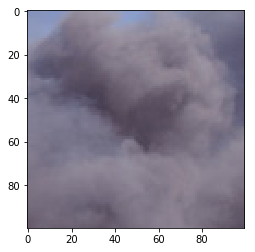

In [18]:
img = plt.imread(smoke_img_list[0])
plt.imshow(img)

### Put all the images in a list

In [19]:
smoke_img = [plt.imread(img_path) for img_path in smoke_img_list]
nonsmoke_img = [plt.imread(img_path) for img_path in nonsmoke_img_list]

In [20]:
smoke_img = np.array(smoke_img)
nonsmoke_img = np.array(nonsmoke_img)
print("smoke image shape: {}".format(smoke_img.shape))
print("non smoke image shape: {}".format(nonsmoke_img.shape))

smoke image shape: (552,)
non smoke image shape: (831, 100, 100, 3)


**Seems that some images in smoke image dataset do not have the standard shape**    
so check for that

In [28]:
for img in smoke_img:
    if (img.shape != (100, 100, 3)):
        print(img.shape)

(110, 100, 3)


### Resize the images to 224x224   
the input image size of VGG is at least 224 x 224, so we need to resize all the images

In [29]:
import cv2
def resize_img(img):
    return cv2.resize(img, (224, 224))

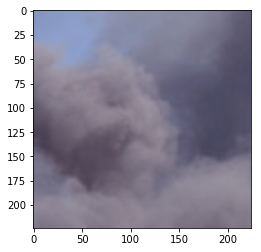

In [30]:
# Test one image at first
plt.imshow(resize_img(smoke_img[1]))

In [31]:
smoke_img_resize = np.array([resize_img(img) for img in smoke_img])
nonsmoke_img_resize = np.array([resize_img(img) for img in nonsmoke_img])

In [32]:
print("resized smoke image shape: {}".format(smoke_img_resize.shape))
print("resized non smoke image shape: {}".format(nonsmoke_img_resize.shape))

resized smoke image shape: (552, 224, 224, 3)
resized non smoke image shape: (831, 224, 224, 3)


### Generate labels
**1** for **smoke image** and **0** for **non smoke image**

In [48]:
smoke_labels = np.ones(smoke_img_resize.shape[0], dtype=np.int8)
nonsmoke_labels = np.zeros(nonsmoke_img_resize.shape[0], dtype=np.int8)

### Split the dataset to train, validation and test sets

In [56]:
# This time I just save the last 20% of the data for test and 15% for validation
X_train = np.concatenate( (smoke_img_resize[:358], nonsmoke_img_resize[:540]) )
y_train = np.concatenate( (smoke_labels[:358], nonsmoke_labels[:540]) )

X_validation = np.concatenate( (smoke_img_resize[358: 442], nonsmoke_img_resize[540: 665]) )
y_validation = np.concatenate( (smoke_labels[358: 442], nonsmoke_labels[540: 665]) )

X_test = np.concatenate( (smoke_img_resize[442:], nonsmoke_img_resize[665:]) )
y_test = np.concatenate( (smoke_labels[442:], nonsmoke_labels[665:]) )

In [ ]:
# for later use
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Load the VGG-19 Model

In [37]:
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [62]:
vgg = applications.vgg19.VGG19( include_top=False, weights='imagenet', input_shape=(224, 224, 3) )

In [66]:
# add the dense layers to the base vgg model
x = vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=predictions)

# train only the top layers
for layer in vgg.layers:
    layer.trainable = False
    
# compile the model
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [68]:
model.fit(x=X_train,
          y=y_train, 
          validation_data=(X_validation, y_validation))

Train on 898 samples, validate on 209 samples
Epoch 1/1
898/898 [==============================] - 619s - loss: 0.7990 - acc: 0.9365 - val_loss: 0.4994 - val_acc: 0.9665

In [ ]:
model.save('first.h5')

## Predict some images

In [71]:
test_img_path = './test-img/2.jpg'

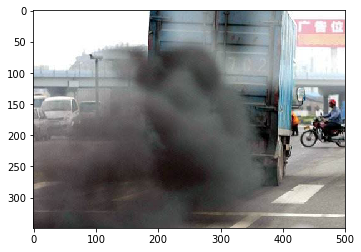

In [72]:
test_img = plt.imread(test_img_path)
plt.imshow(test_img)

In [74]:
model.predict(resize_img(test_img).reshape([1, 224, 224, 3]))

array([[ 0.]], dtype=float32)

In [77]:
test_smoke_part = test_img[200:350, 0:300]

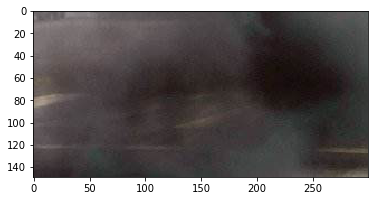

In [78]:
plt.imshow(test_smoke_part)

In [79]:
model.predict(resize_img(test_smoke_part).reshape([1, 224, 224, 3]))

array([[  1.12308348e-29]], dtype=float32)

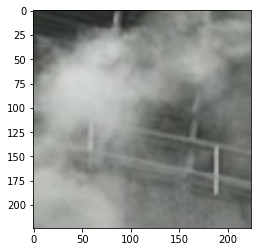

In [80]:
plt.imshow(X_test[10])

In [81]:
model.predict(X_test[10].reshape([1, 224, 224, 3]))

array([[ 1.]], dtype=float32)

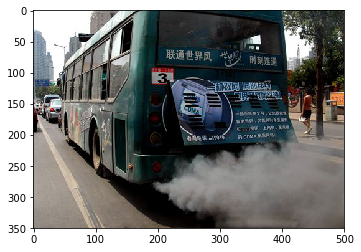

In [82]:
test_img_path = './test-img/4.jpg'
test_img = plt.imread(test_img_path)
plt.imshow(test_img)

In [83]:
model.predict(resize_img(test_img).reshape([1, 224, 224, 3]))

array([[ 0.]], dtype=float32)

In [84]:
test_smoke_part = test_img[250:350, 220:500]

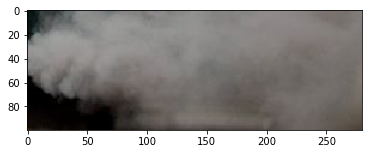

In [85]:
plt.imshow(test_smoke_part)

In [86]:
model.predict(resize_img(test_smoke_part).reshape([1, 224, 224, 3]))

array([[ 1.]], dtype=float32)